# AWS 환경설정

* `export AWS_DEFAULT_PROFILE=ghpipeliner` 실행
* 원하는 aws profile로 잘 변경되었는지 확인
    ```
    aws s3 ls
    ```

In [1]:
import boto3
import pandas as pd
import numpy as np
import json

from datetime import datetime, timedelta

# Load Data

In [2]:
session = boto3.session.Session(profile_name='ghpipeliner')
s3 = session.client('s3')

In [3]:
from_dt = datetime(2023, 1, 2)
to_dt = datetime(2023, 1, 7)

dt = from_dt
df = pd.DataFrame()
cols = ['candle_date_time_kst', 'open', 'high', 'low', 'close', 'volume']
while(dt <= to_dt):
    print(f"Reading {dt}...")
    for hr in range(24):
        file_name = f'{dt + timedelta(hours=hr, minutes=5, seconds=1)} candles.json'
        try:
            response = s3.get_object(Bucket='hb-ohlcv-buy-or-sell', Key=file_name)
        except:
            file_name = f'{dt + timedelta(hours=hr, minutes=5, seconds=2)} candles.json'
            response = s3.get_object(Bucket='hb-ohlcv-buy-or-sell', Key=file_name)
        obj = json.loads(response['Body'].read().decode('utf-8'))
        df = pd.concat([df, pd.DataFrame(obj['candles'])[cols]])
    dt = dt + timedelta(days=1)
    
df.reset_index(drop=True, inplace=True)
df['candle_date_time_kst'] = df['candle_date_time_kst'].astype(dtype=np.datetime64)
df

Reading 2023-01-02 00:00:00...
Reading 2023-01-03 00:00:00...
Reading 2023-01-04 00:00:00...
Reading 2023-01-05 00:00:00...
Reading 2023-01-06 00:00:00...
Reading 2023-01-07 00:00:00...


,candle_date_time_kst,open,high,low,close,volume
0,2023-01-01 23:06:00,21088000.0,21088000.0,21088000.0,21088000.0,0.055518
1,2023-01-01 23:07:00,21088000.0,21099000.0,21088000.0,21088000.0,0.386599
2,2023-01-01 23:08:00,21088000.0,21099000.0,21088000.0,21099000.0,0.097290
3,2023-01-01 23:09:00,21098000.0,21099000.0,21089000.0,21091000.0,0.415292
4,2023-01-01 23:10:00,21099000.0,21099000.0,21090000.0,21099000.0,0.299756
...,...,...,...,...,...,...
8635,2023-01-07 23:01:00,21528000.0,21544000.0,21528000.0,21528000.0,0.605893
8636,2023-01-07 23:02:00,21528000.0,21540000.0,21527000.0,21527000.0,1.467166
8637,2023-01-07 23:03:00,21527000.0,21539000.0,21522000.0,21522000.0,0.715798
8638,2023-01-07 23:04:00,21521000.0,21521000.0,21520000.0,21521000.0,0.716203


# Preprocess Data

In [4]:
df['target'] = df.shift(-1)['close']
data = df.iloc[:len(df) - 1]
data

,candle_date_time_kst,open,high,low,close,volume,target
0,2023-01-01 23:06:00,21088000.0,21088000.0,21088000.0,21088000.0,0.055518,21088000.0
1,2023-01-01 23:07:00,21088000.0,21099000.0,21088000.0,21088000.0,0.386599,21099000.0
2,2023-01-01 23:08:00,21088000.0,21099000.0,21088000.0,21099000.0,0.097290,21091000.0
3,2023-01-01 23:09:00,21098000.0,21099000.0,21089000.0,21091000.0,0.415292,21099000.0
4,2023-01-01 23:10:00,21099000.0,21099000.0,21090000.0,21099000.0,0.299756,21098000.0
...,...,...,...,...,...,...,...
8634,2023-01-07 23:00:00,21545000.0,21546000.0,21528000.0,21528000.0,0.913213,21528000.0
8635,2023-01-07 23:01:00,21528000.0,21544000.0,21528000.0,21528000.0,0.605893,21527000.0
8636,2023-01-07 23:02:00,21528000.0,21540000.0,21527000.0,21527000.0,1.467166,21522000.0
8637,2023-01-07 23:03:00,21527000.0,21539000.0,21522000.0,21522000.0,0.715798,21521000.0


In [5]:
data_train = data.iloc[:int(len(data) * 0.8)]
data_test = data.iloc[int(len(data) * 0.8):]

print('Data for Modeling: ', str(data_train.shape))
print('Unseen Data for Predictions: ', str(data_test.shape))

Data for Modeling:  (6911, 7)
Unseen Data for Predictions:  (1728, 7)


# Train Model

* pycaret sample notebook: [regression tutorial](https://nbviewer.org/github/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Beginner%20-%20REG101.ipynb)

In [6]:
from pycaret.regression import *

In [7]:
exp_reg001 = setup(data=data_train, target='target', session_id=1)

,Description,Value
0,session_id,1
1,Target,target
2,Original Data,"(6911, 7)"
3,Missing Values,0
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(4837, 33)"


In [8]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,7410.9602,101058774.8072,10042.6644,0.9954,0.0005,0.0003,0.0730
en,Elastic Net,7182.8567,103100962.4000,10137.9243,0.9953,0.0005,0.0003,0.0160
llar,Lasso Least Angle Regression,7238.9673,102837306.2672,10124.2232,0.9953,0.0005,0.0003,0.0040
lasso,Lasso Regression,7271.6229,103020713.6000,10133.0709,0.9953,0.0005,0.0003,0.0140
ridge,Ridge Regression,7274.0851,103021064.0000,10133.1139,0.9953,0.0005,0.0003,0.0040
lightgbm,Light Gradient Boosting Machine,7574.2849,104296200.8998,10199.0195,0.9953,0.0005,0.0004,0.0190
huber,Huber Regressor,7152.7694,102906856.2752,10128.9961,0.9953,0.0005,0.0003,0.0070
omp,Orthogonal Matching Pursuit,7208.1386,103282424.4059,10147.5931,0.9953,0.0005,0.0003,0.0040
br,Bayesian Ridge,7179.5187,102964752.8155,10131.8463,0.9953,0.0005,0.0003,0.0080
lr,Linear Regression,7276.2153,103031664.0000,10133.6915,0.9953,0.0005,0.0003,0.5280


In [9]:
huber = create_model('huber')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6892.5908,116801672.1054,10807.4822,0.9947,0.0005,0.0003
1,6545.4653,90090965.2375,9491.6261,0.9959,0.0004,0.0003
2,7582.6716,114145132.3315,10683.8725,0.9950,0.0005,0.0004
3,7138.4377,103055767.6926,10151.6387,0.9956,0.0005,0.0003
4,7506.2224,120175668.1890,10962.4663,0.9944,0.0005,0.0004
5,6685.9579,82942151.6613,9107.2582,0.9964,0.0004,0.0003
6,7849.1978,106927706.4125,10340.5854,0.9950,0.0005,0.0004
7,6882.0022,97556889.8009,9877.0891,0.9953,0.0005,0.0003
8,7244.3092,99683195.0103,9984.1472,0.9957,0.0005,0.0003


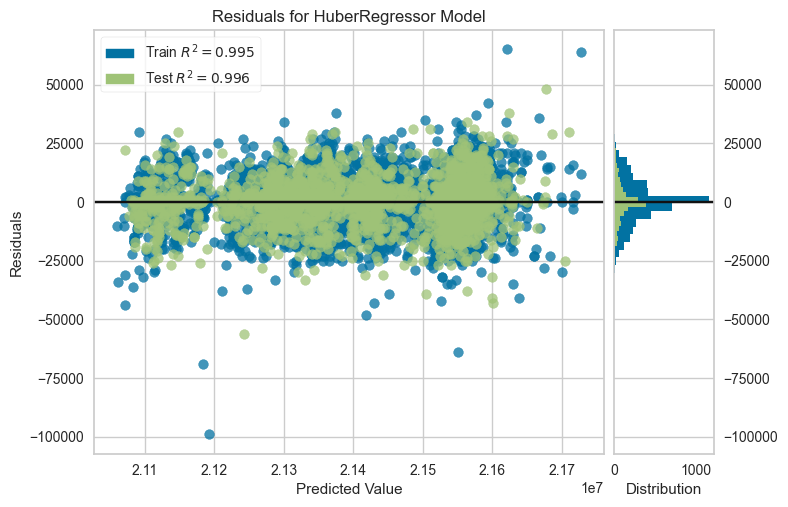

In [10]:
plot_model(huber)

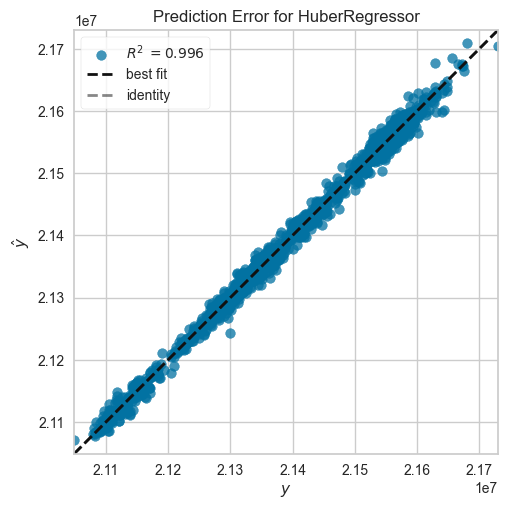

In [11]:
plot_model(huber, plot = 'error')

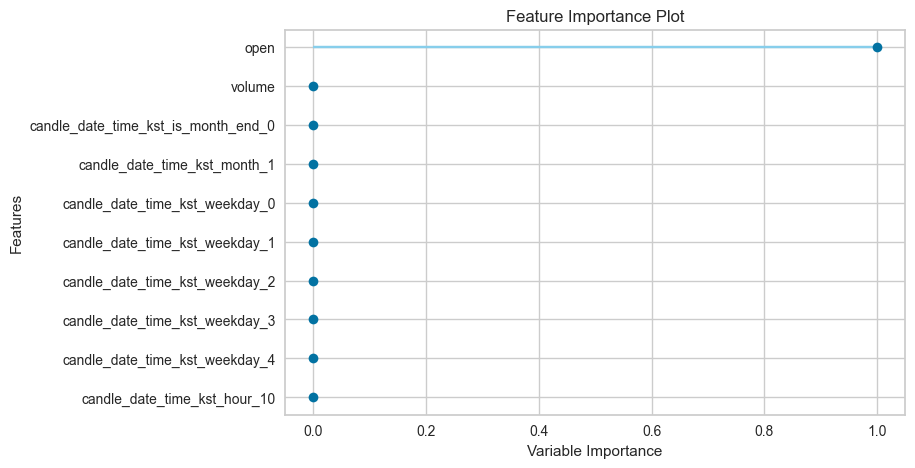

In [12]:
plot_model(huber, plot='feature')

In [13]:
final_huber = finalize_model(huber)
print(final_huber)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)


In [14]:
unseen_predictions = predict_model(huber, data=data_test)
unseen_predictions.head(10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,7771.4296,117309746.6381,10830.9624,0.9805,0.0005,0.0004


,candle_date_time_kst,open,high,low,close,volume,target,Label
6911,2023-01-06 18:17:00,21399000.0,21399000.0,21388000.0,21388000.0,3.622901,21384000.0,2.139900e+07
6912,2023-01-06 18:18:00,21385000.0,21388000.0,21381000.0,21384000.0,3.554742,21375000.0,2.138500e+07
6913,2023-01-06 18:19:00,21381000.0,21384000.0,21375000.0,21375000.0,2.311776,21369000.0,2.138100e+07
6914,2023-01-06 18:20:00,21375000.0,21376000.0,21361000.0,21369000.0,3.284800,21360000.0,2.137500e+07
6915,2023-01-06 18:21:00,21369000.0,21369000.0,21357000.0,21360000.0,1.056958,21351000.0,2.136900e+07
6916,2023-01-06 18:22:00,21362000.0,21369000.0,21350000.0,21351000.0,6.103427,21367000.0,2.136200e+07
6917,2023-01-06 18:23:00,21352000.0,21369000.0,21350000.0,21367000.0,1.070098,21365000.0,2.135200e+07
6918,2023-01-06 18:24:00,21365000.0,21370000.0,21356000.0,21365000.0,2.468427,21376000.0,2.136500e+07
6919,2023-01-06 18:25:00,21370000.0,21376000.0,21365000.0,21376000.0,1.418802,21386000.0,2.137000e+07
6920,2023-01-06 18:26:00,21376000.0,21398000.0,21373000.0,21386000.0,1.961358,21398000.0,2.137600e+07


In [15]:
from pycaret.utils import check_metric

In [16]:
check_metric(unseen_predictions['target'], unseen_predictions['Label'], 'R2')

0.9805

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

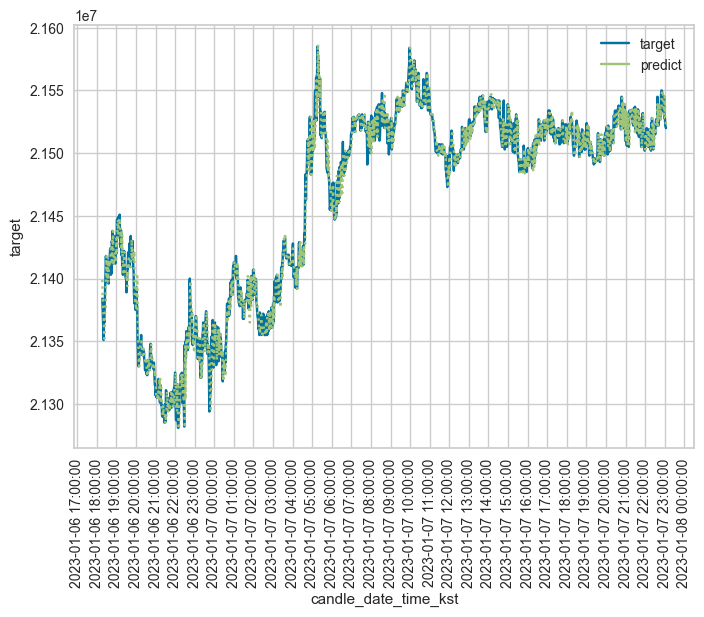

In [18]:
fig, ax = plt.subplots()

sns.lineplot(data = unseen_predictions, x='candle_date_time_kst', y='target', label='target', ax=ax)
sns.lineplot(data = unseen_predictions, x='candle_date_time_kst', y='Label', label='predict', ax=ax)

ax.lines[1].set_linestyle(":")
# x_dates = unseen_predictions['candle_date_time_kst'].astype(dtype=np.datetime64).dt.strftime('%Y-%m-%d %H:%M:%S').sort_values().unique()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), rotation=90)
fig.show()